## Introduction:
Context:\
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.\
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.\
Data Sourced from: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data

# Importing Necessary Libraries


In [211]:
import kaleido
#For Data Manipulation
import pandas as pd 
#Statistics/Lin. Algebra
from scipy import stats
import numpy as np
#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
#Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
#ML
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

## Additional Information: 
Attribute Information

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient



### Reading in the file and finding summary statistics

In [31]:
stroke = pd.read_csv('/Users/ice50l/Downloads/stroke.csv')
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [32]:
df = stroke.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [33]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


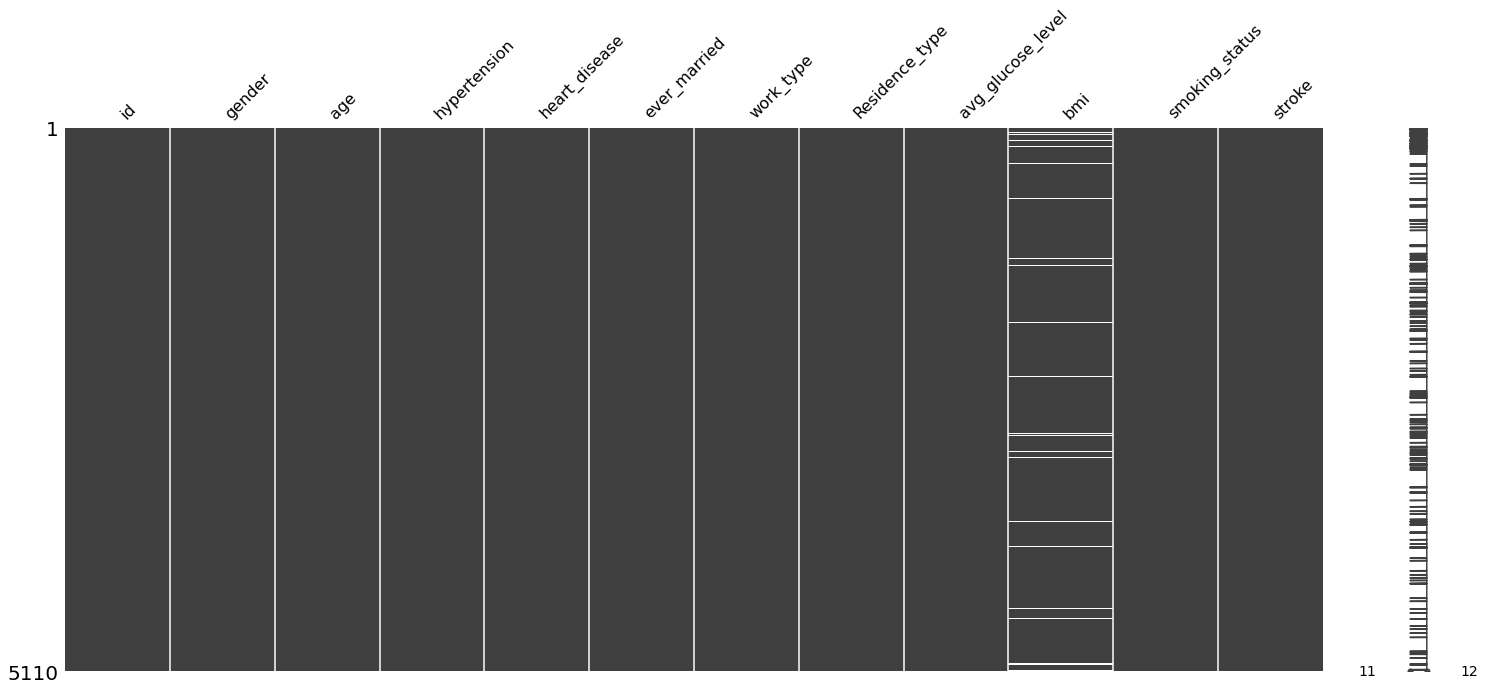

In [34]:
#Using the missingno library to visualize missing values
msno.matrix(df)
plt.show()

### BMI appears to suffer from many missing values, we can impute values into the missing cells using mean imputation.

In [35]:
converted = df.copy()
work_type_mapping = {'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4}

# Map the values using the created dictionary
converted['work_type'] = converted['work_type'].map(work_type_mapping)


#Converting Location
Residence_type_mapping = {'Urban': 0, 'Rural': 1}

# Map the values using the created dictionary
converted['Residence_type'] = converted['Residence_type'].map(Residence_type_mapping)


#Converting Gender
gender_mapping = {'Male': 0, 'Female': 1, 'Other': 2}

# Map the values using the created dictionary
converted['gender'] = converted['gender'].map(gender_mapping)


#Converting smoking status
smoking_status_mapping = {'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3}

# Map the values using the created dictionary
converted['smoking_status'] = converted['smoking_status'].map(smoking_status_mapping)


#Converting married status
married_mapping = {'Yes': 0, 'No': 1}
converted['ever_married'] = converted['ever_married'].map(married_mapping)

### We are converting all categorical values to numeric for later use.

In [36]:
#Imputing the mean for BMI column
features = converted.columns.difference(['bmi'])

imputer = SimpleImputer(strategy='mean')

# Perform imputation for the target column
converted['bmi'] = imputer.fit_transform(converted[['bmi']])

In [37]:
converted = converted.drop('id', axis = 1)

## What is ANOVA?
Analysis of Variance or ANOVA, is an analysis tool that splits observed aggregate variability into two parts: systemic factors and random factors.\
Systemic factors have a statistical influence on the dataset, while random factors do not have a statistical influence. 

## The formula for ANOVA is denoted by F = MST/MSE
F = ANOVA coefficient\
MST = Mean sum of squares due to treatment\
MSE = Mean sum of squares due to error

## One-Way ANOVA vs. Two-Way ANOVA
One-Way and Two-Way are the main types of ANOVA.\
Determining One-Way and Two-Way is based on the amount of indepdent variables in your ANOVA test.\
A One-Way ANOVA test evaluates the sole factor on a sole response variable, this test determines if there are any statisical significance between the means of 3 or more independent groups.

## Additional Information: 
ANOVA compares two or more groups at the same time to determine if a relationship between these variables exist between one another.

Source: https://www.investopedia.com/terms/a/anova.asp

In [38]:
num_cols = list(converted.select_dtypes('float64').columns)
unrelated_num_cols = []
categorical_col = 'stroke'

for i in num_cols:
    # Perform Kruskal-Wallis test
    grouped_data = [converted[i][converted[categorical_col] == category] for category in converted[categorical_col].unique()]
    statistic, p_value = stats.f_oneway(*grouped_data)

    # Set the significance level (alpha)
    alpha = 0.05

    # Print the results with appropriate text color
    if p_value < alpha:
        print( f"ANOVA statistic: {round(statistic, 2)}")
        print(f"p-value: {p_value}")
        print("\033[32m" + f"Reject the null hypothesis: There is a significant relationship between {i} and {categorical_col}")
        print("\033[0m")  # Reset text color to default
    else:
        print( f"ANOVA statistic: {round(statistic, 2)}")
        print(f"p-value: {p_value}")
        print("\033[31m" + f"No significant relationship between {i} and {categorical_col}")
        print("\033[0m")  # Reset text color to default
        unrelated_num_cols.append(i)

ANOVA statistic: 326.92
p-value: 7.030777513003522e-71
Reject the null hypothesis: There is a significant relationship between age and stroke

ANOVA statistic: 90.5
p-value: 2.767810519477541e-21
Reject the null hypothesis: There is a significant relationship between avg_glucose_level and stroke

ANOVA statistic: 7.76
p-value: 0.005361957129412403
Reject the null hypothesis: There is a significant relationship between bmi and stroke



### Using ANOVA to show if there are any significant relationships between variables or not.

## EXPLORATORY DATA ANALYSIS (EDA)

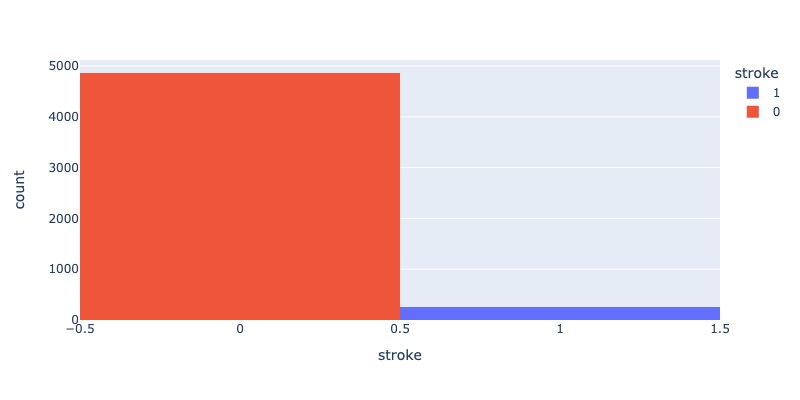

In [212]:
fig = px.histogram(data_frame=converted, x="stroke", color = 'stroke', width=800, height=400)
fig.show(renderer = 'jpeg')

### It appears that the data is very unbalanced, there are way more people that have suffered a stroke compared to those that have no suffered from a stroke.

In [40]:
converted.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,0,228.69,36.600000,0,1
1,1,61.0,0,0,0,1,1,202.21,28.893237,1,1
2,0,80.0,0,1,0,0,1,105.92,32.500000,1,1
3,1,49.0,0,0,0,0,0,171.23,34.400000,2,1
4,1,79.0,1,0,0,1,1,174.12,24.000000,1,1


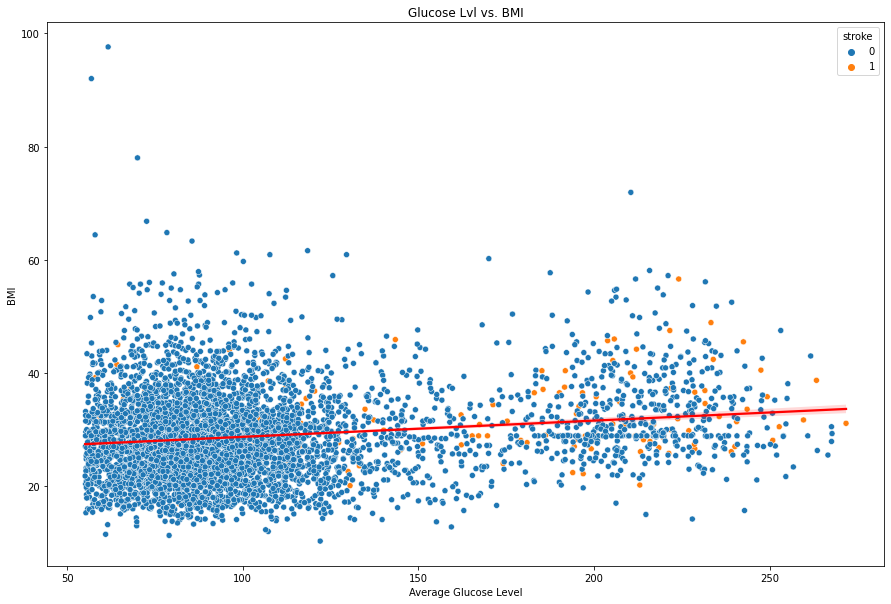

In [41]:
plt.figure(figsize = (15,10))
sns.scatterplot(data = converted, x = 'avg_glucose_level', y = 'bmi', hue = 'stroke')
sns.regplot(data = converted, x = 'avg_glucose_level', y = 'bmi', scatter = False, ci = 95, line_kws={"color": "red"})
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.title('Glucose Lvl vs. BMI')
plt.show()

### There appears to be a slight positive correlation between Glucose Level and BMI, and another point of observation is that most people that have a stroke is below 60 BMI.

<Figure size 1080x720 with 0 Axes>

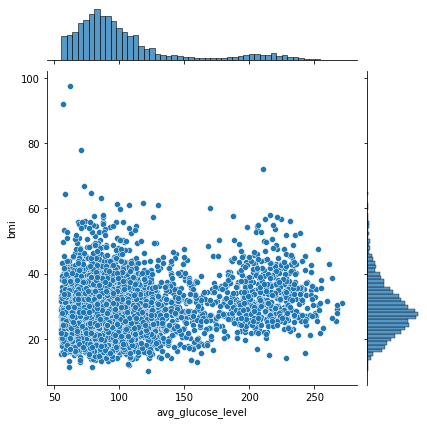

In [42]:
#Using a marginal plot to determine the relationship between glucose level and bmi while getting distribution information.
plt.figure(figsize = (15,10))
sns.jointplot(x=df["avg_glucose_level"], y=df["bmi"], kind='scatter')
plt.show()

In [43]:
fig = px.pie(df, names='gender', hole=0.4, color='gender', color_discrete_sequence=['blue', 'pink'])

# Update layout to create a donut plot, set size
fig.update_traces(textinfo='percent+label', pull=[0.1, 0], hoverinfo='label+percent')
fig.update_layout(
    title='Gender Distribution',
    annotations=[dict(text='Gender', x=0.5, y=0.5, font_size=20, showarrow=False)],
    height=400,  # Set the height of the plot
    width=400,   # Set the width of the plot
)

# Show the plot
fig.show()

### We are figuring out the gender distribution percentage using a donut plot.

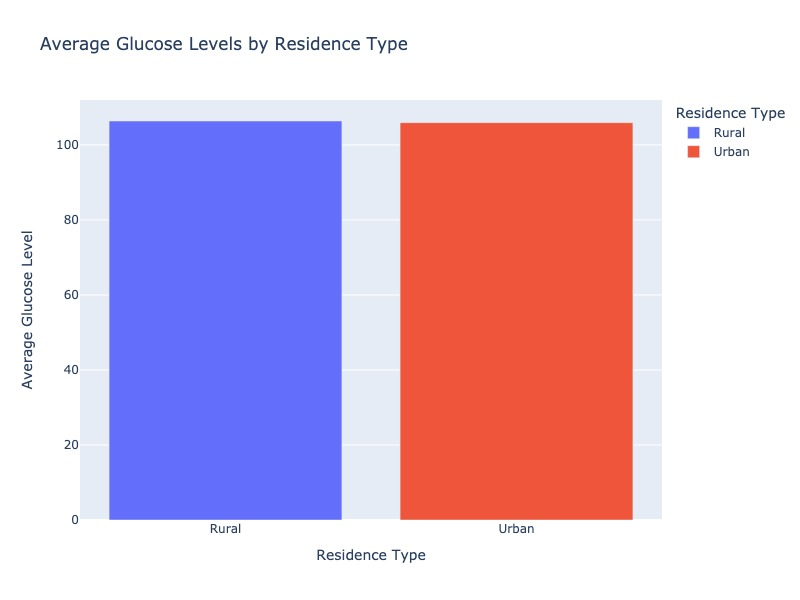

In [213]:
grouped = df.groupby('Residence_type')['avg_glucose_level'].agg(average_glucose = 'mean').reset_index()
fig = px.bar(grouped, x='Residence_type', y='average_glucose', color='Residence_type',
             title='Average Glucose Levels by Residence Type',
             labels={'average_glucose': 'Average Glucose Level', 'Residence_type': 'Residence Type'})
fig.update_layout(
    height=600,  # Set the height of the plot
    width=800)
fig.show(renderer = 'jpeg')


### The average glucose level by residence type appears to be about equal, there are no anomalies here.

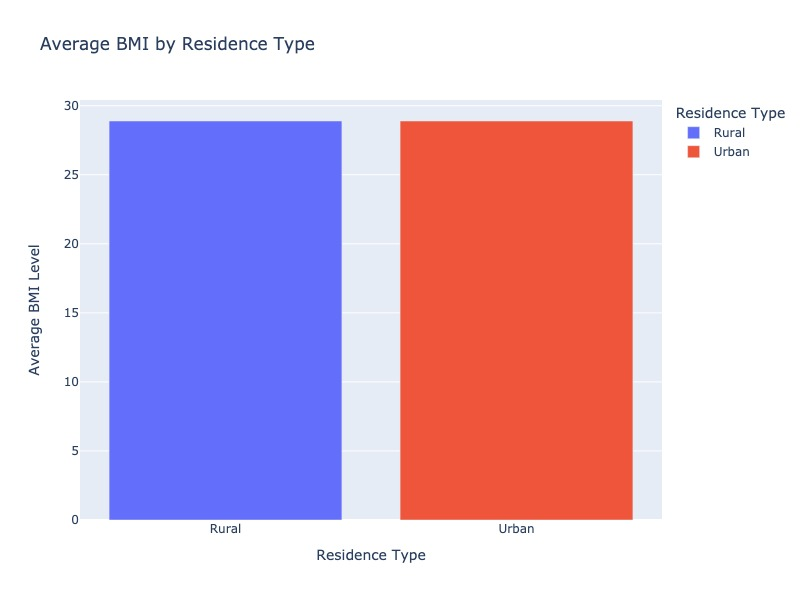

In [214]:
grouped2 = df.groupby('Residence_type')['bmi'].agg(bmi = 'mean').reset_index()
fig = px.bar(grouped2, x='Residence_type', y='bmi', color='Residence_type',
             title='Average BMI by Residence Type',
             labels={'bmi': 'Average BMI Level', 'Residence_type': 'Residence Type'})
fig.update_layout(
    height=600,  # Set the height of the plot
    width=800)
fig.show(renderer = 'jpeg')

### There does not appear to be an anomalies in residence type and BMI, they appear to be approximately equal.

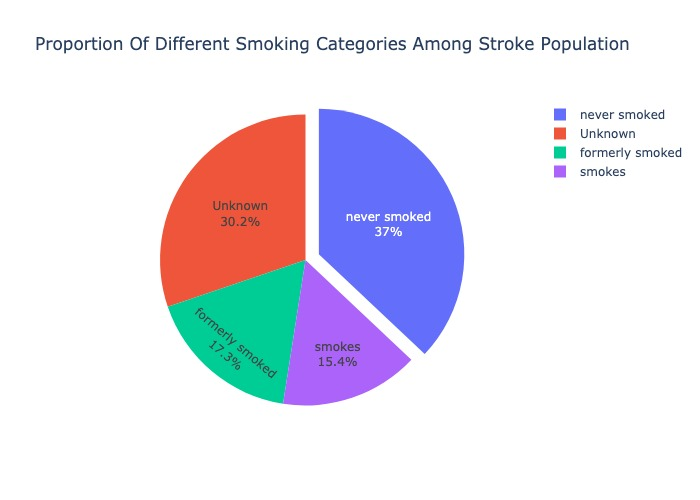

In [215]:
# Determining the distribution for smoking status

fig = px.pie(df, names='smoking_status', title='Proportion Of Different Smoking Categories Among Stroke Population')

# Find the category with the largest proportion
largest_category = df['smoking_status'].value_counts().idxmax()

# Pull out the largest slice
fig.update_traces(pull=[0.1 if category == largest_category else 0 for category in df['smoking_status']],
                  textinfo='percent+label', hoverinfo='label+percent')
fig.update_layout(
    height=500,  # Set the height of the plot
    width=700    # Set the width of the plot
)

# Show the plot
fig.show(renderer = 'jpeg')

Text(0.5, 1.0, 'Age vs BMI')

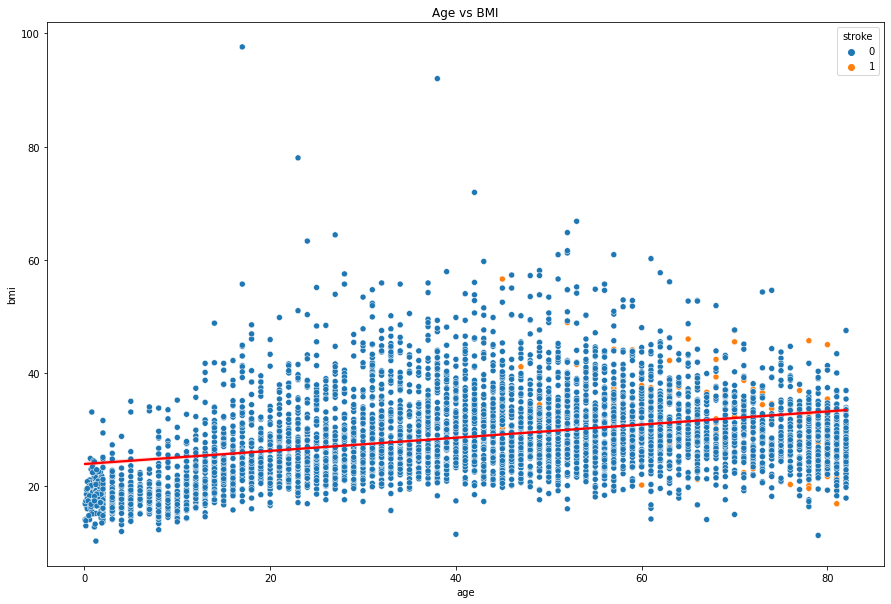

In [47]:
plt.figure(figsize = (15,10))
sns.scatterplot(data = df, x = 'age', y = 'bmi', hue = 'stroke')
sns.regplot(data = df, x = 'age', y = 'bmi', scatter = False, ci = 95, line_kws={"color": "red"})
plt.title('Age vs BMI')

### There appears to be a weak positive correlation between the age and bmi and it appears that most of the people that suffered a stroke are below the range of 60 BMI.

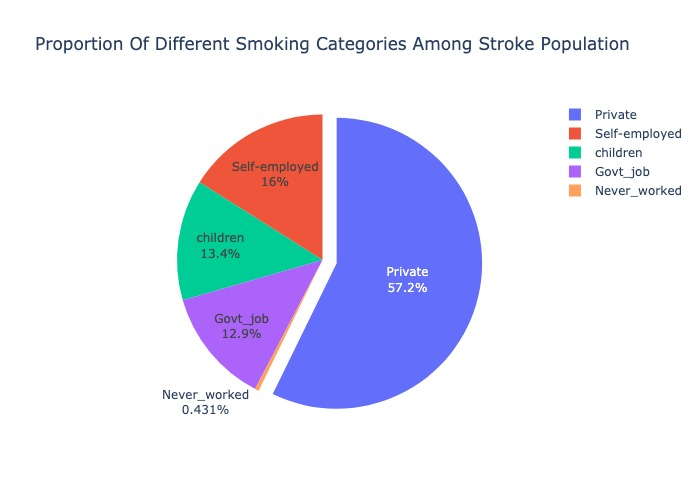

In [216]:
# Determining the distribution for work type

fig = px.pie(df, names='work_type', title='Proportion Of Different Smoking Categories Among Stroke Population')

# Find the category with the largest proportion
largest_category = df['work_type'].value_counts().idxmax()

# Pull out the largest slice
fig.update_traces(pull=[0.1 if category == largest_category else 0 for category in df['work_type']],
                  textinfo='percent+label', hoverinfo='label+percent')
fig.update_layout(
    height=500,  # Set the height of the plot
    width=700    # Set the width of the plot
)

# Show the plot
fig.show(renderer = 'jpeg')

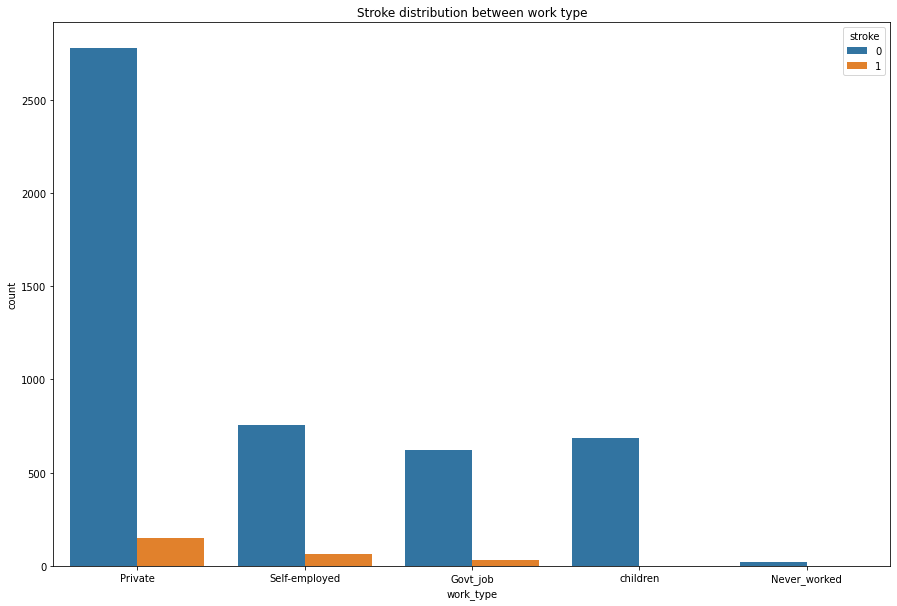

In [49]:
plt.figure(figsize = (15,10))
sns.countplot(data = df, x = 'work_type', hue = 'stroke')
plt.title("Stroke distribution between work type")
plt.show()

### There appears to be a large amount of people working in private sectors that get strokes.

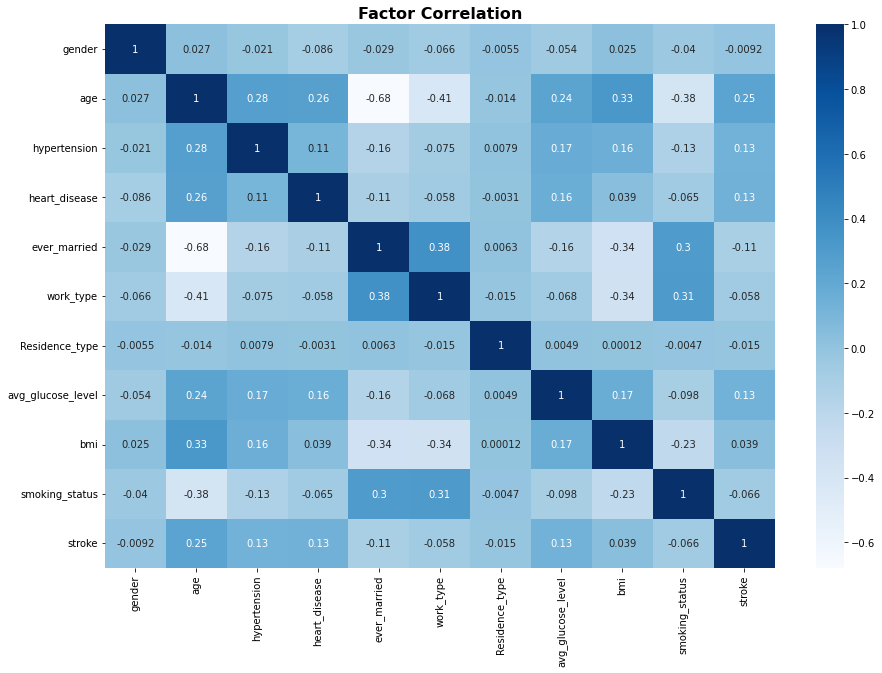

In [209]:
# Correlation between each factor
corr = converted.corr()
plt.figure(figsize = (15,10))
sns.heatmap(corr, cmap = 'Blues', annot = True)
plt.title("Factor Correlation", fontweight = "bold", fontsize=16)
plt.show()

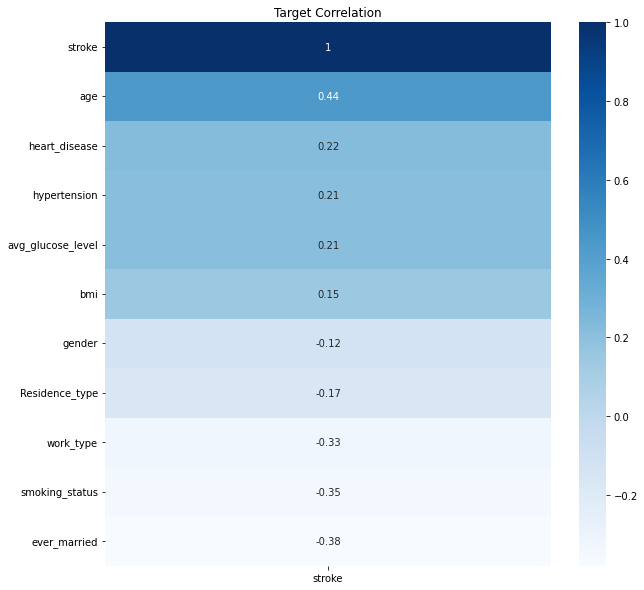

In [210]:
# Correlation for the target variable (stroke)
plt.figure(figsize = (10,10))
sns.heatmap(corr.corr()[['stroke']].sort_values(by='stroke', ascending=False), annot = True, cmap = 'Blues')
plt.title('Target Correlation')
plt.show()

### Zooming in on target (stroke) correlation with other variables.

# Feature Scaling and upscaling:

In [145]:
stroke = converted[converted.stroke == 1]
not_stroke = converted[converted.stroke == 0].sample(n = 1000,random_state=42)
data_conv = pd.concat([stroke, not_stroke])

In [146]:
X = data_conv.drop('stroke', axis = 1)
y = data_conv['stroke']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [148]:
# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Applying SMOTE to oversample data due to the inbalance of target variables.

### What is SMOTE?
SMOTE AKA Synthetic Minority Oversampling Technique is an oversampling method of balancing class distribution in the dataset. It selects minority examples that are close to the feature space then it draws a line between examples in the the feature space then draws a new sample at the point that is near that line.\
This technique is used when there is a large inbalance in the dataset, and in this case, there is a large disparity between people that have had a stroke and those that do not.\
This algorithm selects a random example from the minority class and selects a random neighbor using the K-Nearest Neighbors algorithm.

### What are the drawbacks?
The drawback of using SMOTE is that it does not consider the majority class (only the minority) when it chooses its samples. What does this mean? This means that it can cause issues where there are strong overlaps between classes. This should be considered before using the SMOTE library.

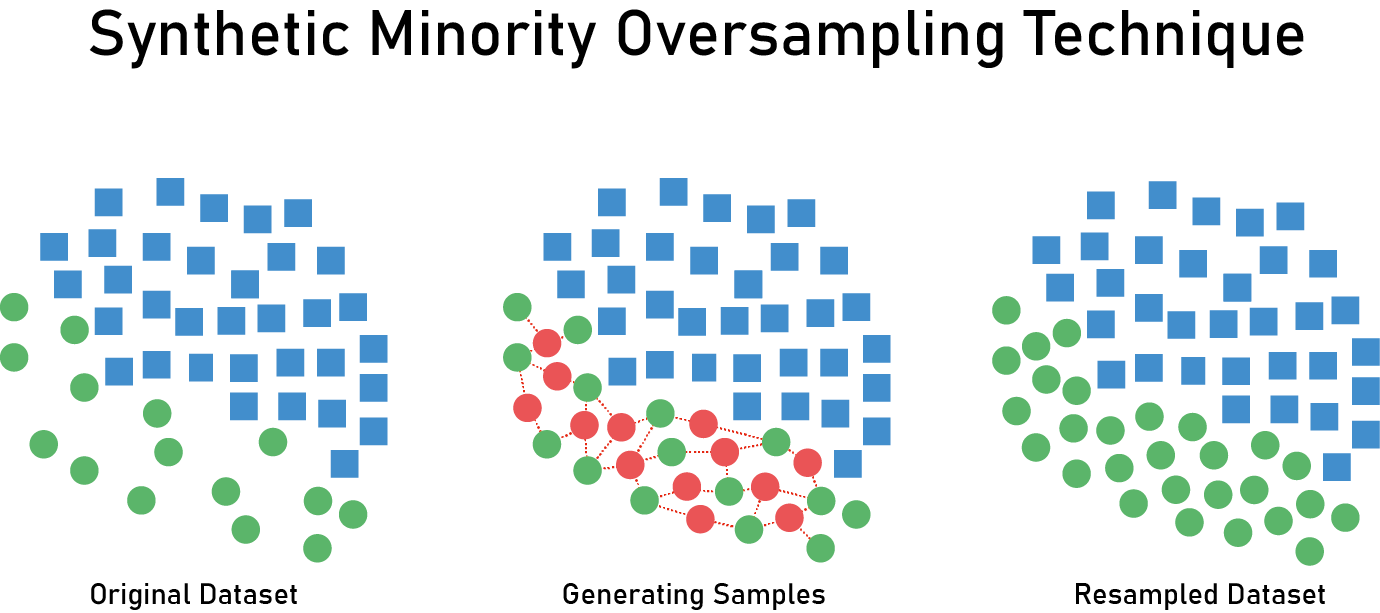

Source: https://www.kdnuggets.com/2022/11/introduction-smote.html#:~:text=SMOTE%20(Synthetic%20Minority%20Oversampling%20Technique)%20is%20an%20oversampling%20method%20of,a%20point%20along%20that%20line.

### Additional SMOTE usage source: 
https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

### Though SMOTE is not used in this project, it is something that can be considered when there is an inbalance in the data. However there are many cataegorical values and machine learning algorithms such as random forest classifier and decision trees handle these well.
The times to NOT use SMOTE:
- When the class inbalance is too extreme
- When the minority class has complex and diverse patterns that cannot be oversampled.
- If there is high class overlap.

# Useful Functions Creation:

## We will define useful functions that will be carried out throughout model selection. One of these functions is the creation of the ROC curve.

## What is an ROC curve?
An ROC curve or receiver operating characteristics curve is a graph that shows the performance of a classification model at all of the common thresholds. This curve contains 2 parameters:
- True Positive Rate
- False Positive Rate

The true positive rate can be defined as recall and is denoted by the formula:\
### TPR = TP / TP + FN

The false positive rate is denoted by the formula:\
### FPR =  FP / FP + TN

An ROC curve plots TPR against FPR at different classification thresholds. If you lower the classification threshold, more items will be classified as positive which will also increase the rate of false positives and true positives.\

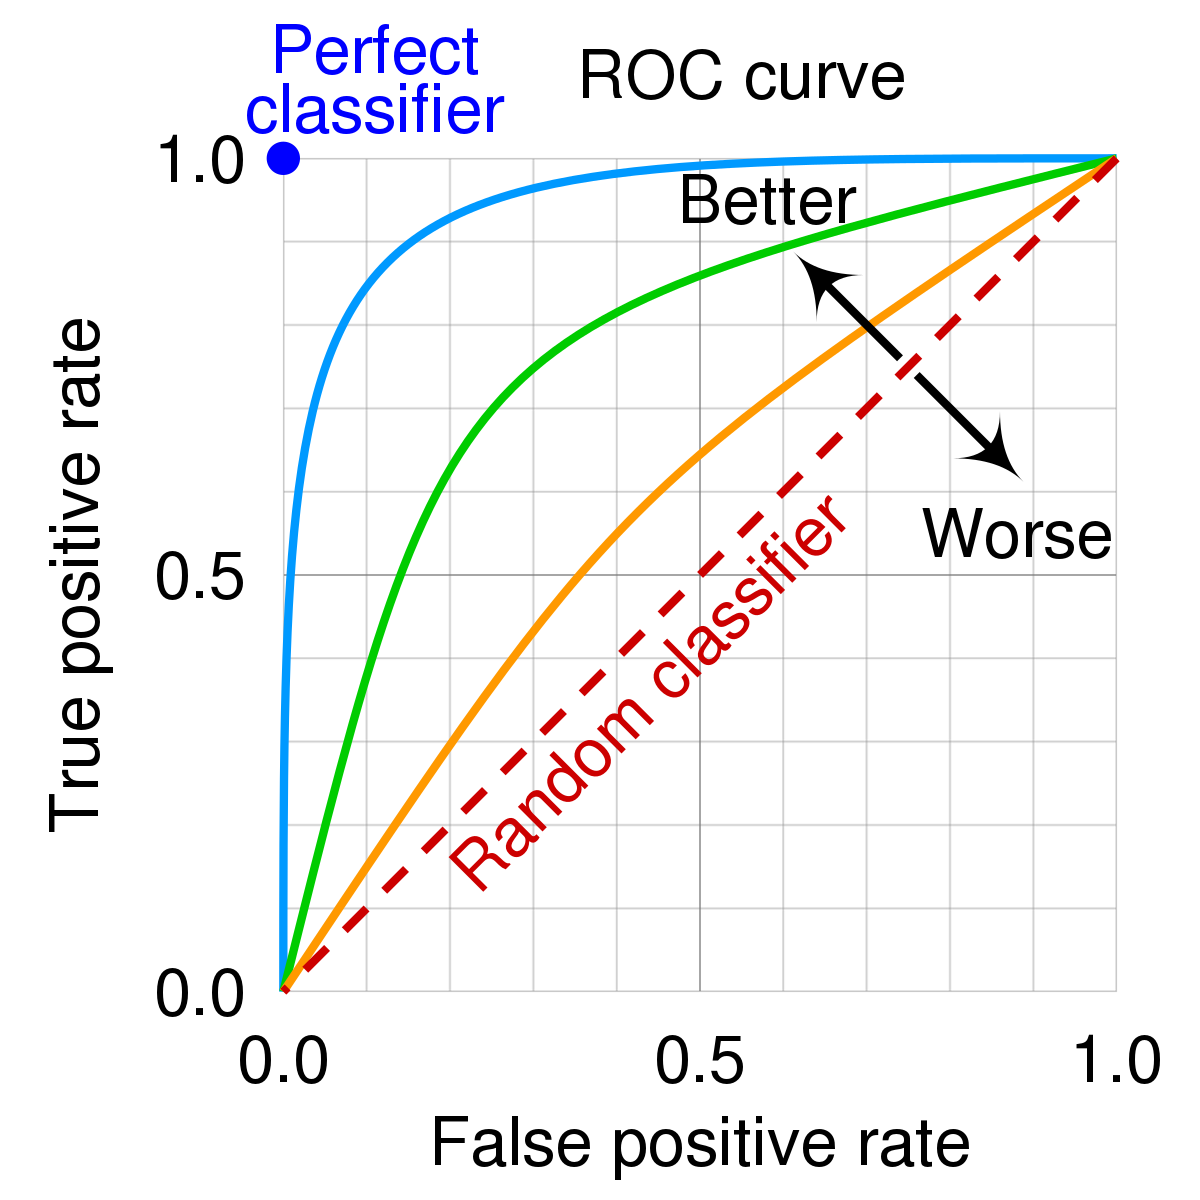

Source: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [149]:
from sklearn.metrics import roc_curve

def plot_roc_curve(model, y_test, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

    plt.figure(figsize = (15,10))
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model + ' ROC Curve')
    plt.show()

## What is a learning curve?
A learning curve in machine learning is a graphic that plots the optimal value of a model's loss function for a training set compared to the loss function of the validation set with the same parameters that are provided at the optimal function.\
Synonyms:
- Error Curve
- Experience Curve
- Improvement Curve
- Generalization Curve

## What does a training curve do?
The training curve will essentially show changes in learning performance over time in terms of the experience.\
It will diagnose underfitting, overfitting, or if it is a model that is well fitted.

## Underfitting:
Underfitting means a model cannot learn the training data. Underfitting occurs when the model is not able to obtain a low error value on the training set. \
Underfitting is seen in a learning curve when training loss remains flat regardless of training and the training loss continues to decrease up until the end of the training.

## Overfitting:
Overfitting occurs when the model learns the data "too well" to the point where it will give you a high correct percentage, up until the point you add new values. Then it will not properly predict the new observations.\
Overfitting is seen in a learning curve when training loss continues to decrease while experience increases.


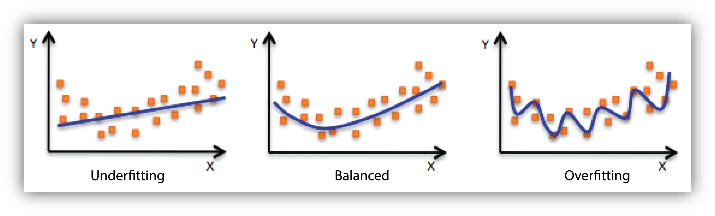\
Source: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

In [150]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(X, y, estimator, num_trainings):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1, num_trainings))
    print(np.linspace(.1,1, num_trainings))
    print(train_sizes)
    print(train_scores)
    print(test_scores)

    train_scores_mean = np.mean(train_scores, axis = 1)
    print(train_scores_mean)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.figure(figsize = (15,10))
    plt.grid()
    plt.title('Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = .1, color = 'g')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = .1, color = 'r')

    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'g', label = 'Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'y', label = 'Cross-validation score')
    plt.legend(loc = 'best')
    plt.show()

## What is a confusion matrix?
A confusion Matrix is a table that assess the performance of a classifcation model. It summarizes the result of the classification by showing counts of true positive, true negative, false positive, and false negative predictions by the model.\
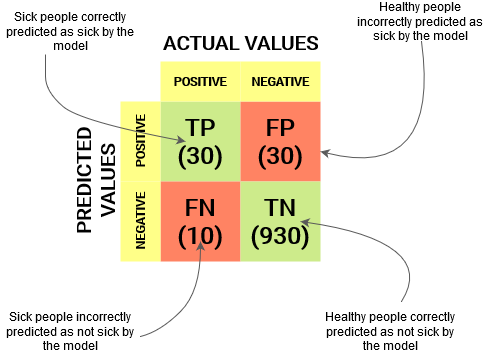

In [151]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, y_test, y_pred):

    plt.figure(figsize = (15,10))
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt = 'g')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(model + ' Confusion Matrix')

## Model Selection

## Random Forest Classifier
What is the Random Forest Classifier?
The random forest classifier is a machine learning algorithm that reduces overfitting by averaging multiple decision trees. This algorithm is also less sensitive to outliers and noise that are within the data.\
Benefits of using the random forest classifier:
- High accuracy
- Determines feature importance
- Versitile
- Scalable

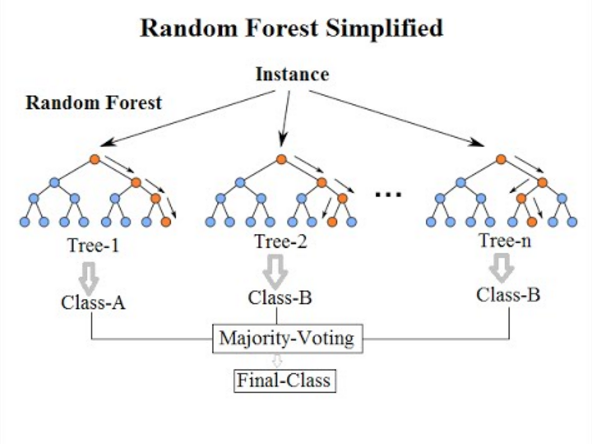\
Source: https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/

In [185]:
rf = RandomForestClassifier(random_state = 42)
# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'n_estimators': [50, 100],
             "criterion": ['gini', 'entropy', 'log_loss']
             }  


# Instantiate GridSearch
gridrfc2 = GridSearchCV(rf, cv_params, cv=4)
gridrfc2.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, None], 'n_estimators': [50, 100]})

In [186]:
print(f'The Best Score for Grid Searched RFC is: {gridrfc2.best_score_}')
print(f'The Best parameters for Grid Searched RFC is: {gridrfc2.best_params_}')

The Best Score for Grid Searched RFC is: 0.8034188034188035
The Best parameters for Grid Searched RFC is: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}


In [187]:
rf = RandomForestClassifier(criterion = 'gini', max_depth = 3, n_estimators = 50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_pred, y_test)
print(f'The Score for Random Forest Classifier is: {rf_acc}')

The Score for Random Forest Classifier is: 0.805111821086262


In [188]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       300
           1       0.10      0.46      0.16        13

    accuracy                           0.81       313
   macro avg       0.54      0.64      0.53       313
weighted avg       0.94      0.81      0.86       313



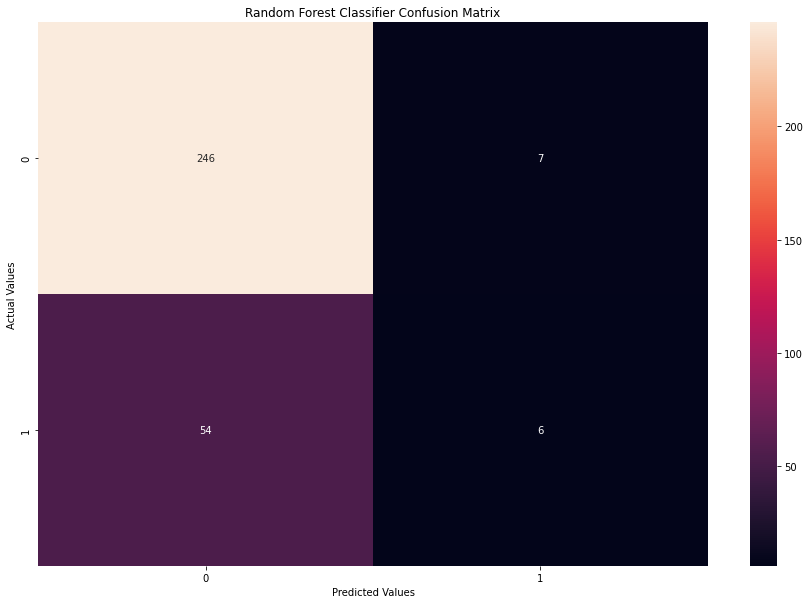

In [189]:
plot_confusion_matrix('Random Forest Classifier', y_test, y_pred)

[0.1   0.325 0.55  0.775 1.   ]
[ 25  81 137 193 250]
[[0.96       1.         1.         0.96       1.        ]
 [0.9382716  0.9382716  0.92592593 0.92592593 0.91358025]
 [0.86131387 0.86861314 0.88321168 0.89051095 0.87591241]
 [0.86010363 0.84974093 0.87046632 0.83937824 0.86528497]
 [0.836      0.852      0.856      0.84       0.868     ]]
[[0.82539683 0.80952381 0.80952381 0.79032258 0.77419355]
 [0.80952381 0.82539683 0.80952381 0.79032258 0.77419355]
 [0.82539683 0.79365079 0.79365079 0.80645161 0.75806452]
 [0.80952381 0.82539683 0.80952381 0.80645161 0.79032258]
 [0.80952381 0.80952381 0.80952381 0.79032258 0.79032258]]
[0.984      0.92839506 0.87591241 0.85699482 0.8504    ]


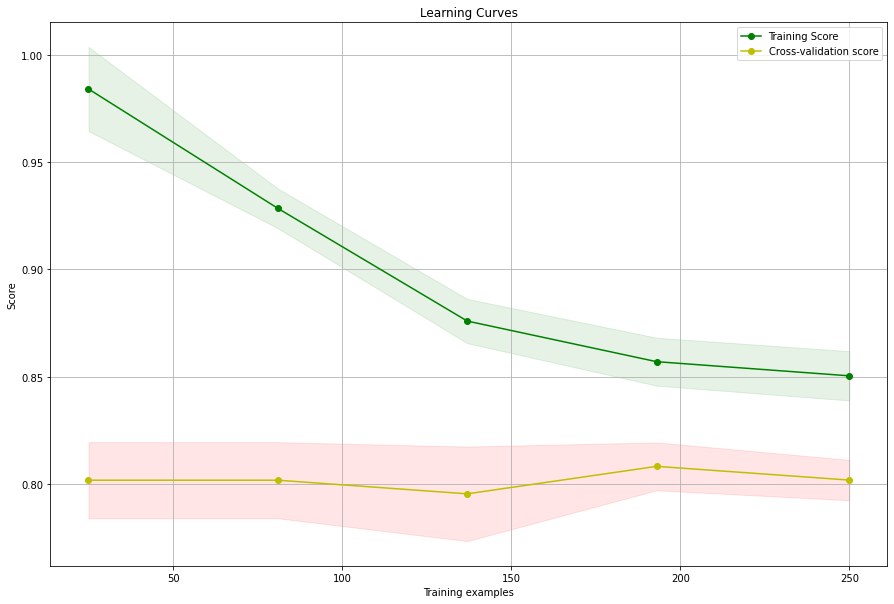

In [190]:
plot_learning_curve(X_test,y_test, rf, 5)

In [191]:
y_pred_probs = rf.predict_proba(X_test)[:,1]
print(f'The Probability is: {y_pred_probs[0]}')
print('The AUC Score is:',roc_auc_score(y_test, y_pred_probs))

The Probability is: 0.10738440099005649
The AUC Score is: 0.8383728590250329


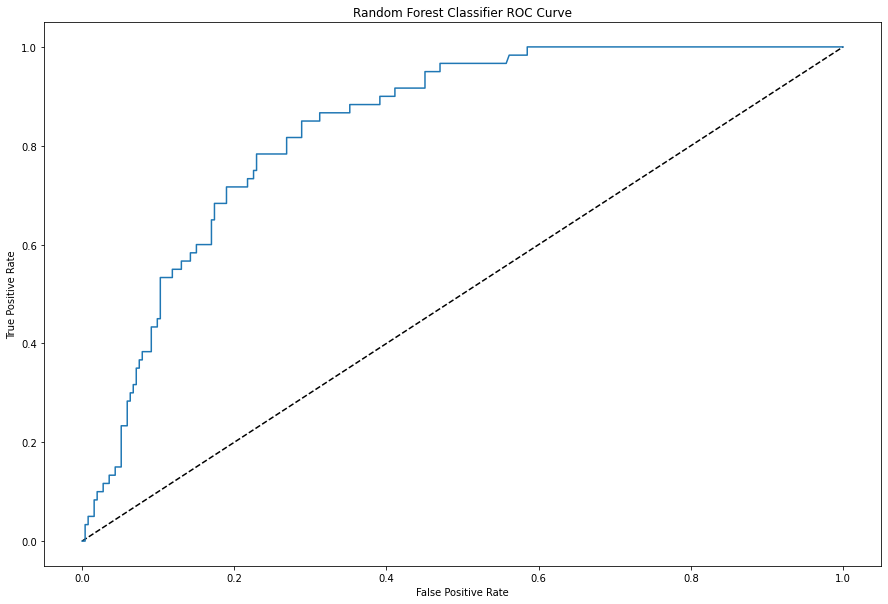

In [192]:
plot_roc_curve('Random Forest Classifier', y_test, y_pred_probs)

Text(0, 0.5, 'Features')

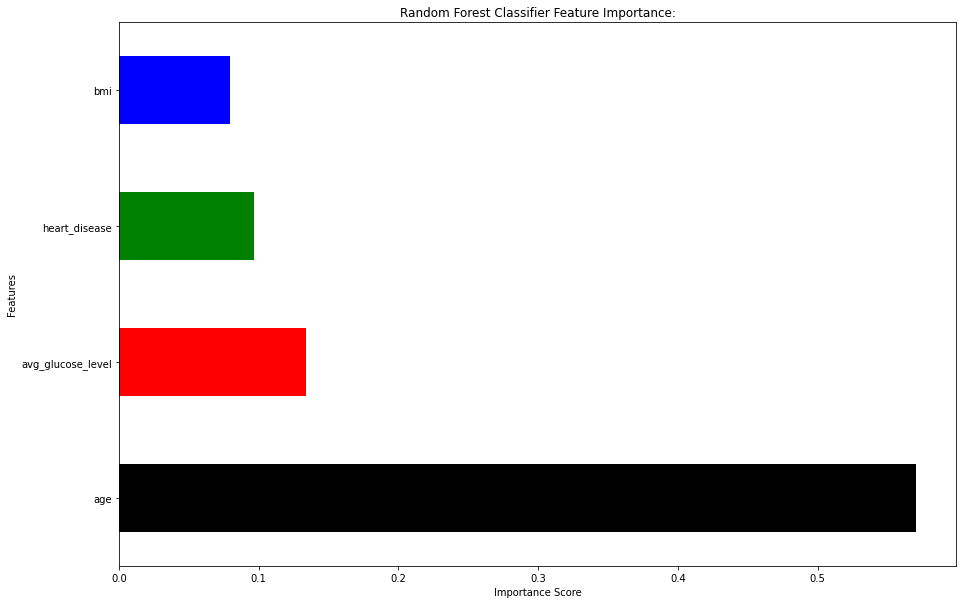

In [193]:
plt.figure(figsize = (15,10))
pd.Series(rf.feature_importances_, index=X.columns).nlargest(4).plot(kind='barh', color = ['black', 'red', 'green', 'blue'])
plt.title('Random Forest Classifier Feature Importance:')
plt.xlabel('Importance Score')
plt.ylabel('Features')

### It appears that age is significantly important to the model compared to other variables.

## Logistic Regression:
What is logisitc regression? 
Logistic regression is a technique to find the relationship between two data factors. The relationship is used then to predict the value of one of the factors based on the other. \
It predicts the probability of an event occurring. An example would be: If someone voted or if someone didn't vote based on the given data of independent variables.

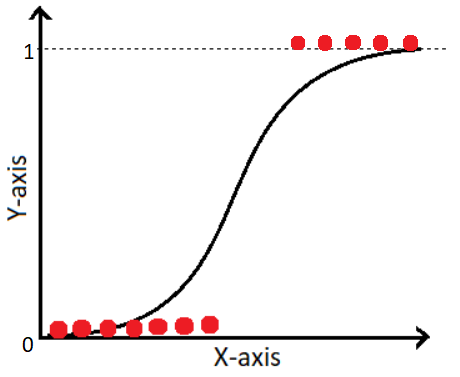

Source: https://www.ibm.com/topics/logistic-regression



In [172]:
logreg = LogisticRegression(random_state = 42)
param_dist = {
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear'],
    'C': stats.uniform(0.01, 10).rvs(size=100)
}


gridlogreg = GridSearchCV(logreg, param_dist, cv=4)
gridlogreg.fit(X_train, y_train)


GridSearchCV(cv=4, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([5.63553407, 8.28043799, 1.68933467, 4.08910893, 7.83292291,
       7.84659084, 4.16555422, 7.82150469, 2.73289799, 7.85175337,
       6.86513746, 3.86969765, 0.26745081, 7.12677795, 3.3479539 ,
       2.4081454 , 0.11538203, 8.67426867, 0.3950746 , 9.58199071,
       9.79268033, 2.82385159, 4.75464074, 0.05975434, 6....
       7.49324032, 1.54771013, 5.19306666, 5.87990961, 1.65386948,
       0.32941953, 3.15679781, 3.17726991, 4.25079468, 6.29287265,
       1.70218263, 9.54716132, 6.33788474, 2.36482714, 8.6662668 ,
       7.77300201, 1.03385715, 6.48498585, 2.02527681, 8.8913136 ,
       3.18153902, 3.60612152, 8.08217806, 9.18999337, 0.58418122,
       6.02035463, 8.56811966, 8.73633237, 9.76435957, 9.54901394]),
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga',
                                    'liblinear']})

In [173]:
print(f'The Best Score for Grid Searched Logreg is: {gridlogreg.best_score_}')
print(f'The Best parameters for Grid Searched Logreg is: {gridlogreg.best_params_}')

The Best Score for Grid Searched Logreg is: 0.8258547008547009
The Best parameters for Grid Searched Logreg is: {'C': 0.7140621459949803, 'solver': 'liblinear'}


In [174]:
lr = LogisticRegression(C = 0.09382015354276517, solver = 'liblinear', random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_pred, y_test)
print(f'The Score for Logistic Regression is: {lr_acc}')

The Score for Logistic Regression is: 0.8083067092651757


In [175]:
print(classification_report(y_pred, y_test, zero_division=1))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       273
           1       0.33      0.50      0.40        40

    accuracy                           0.81       313
   macro avg       0.63      0.68      0.64       313
weighted avg       0.85      0.81      0.82       313



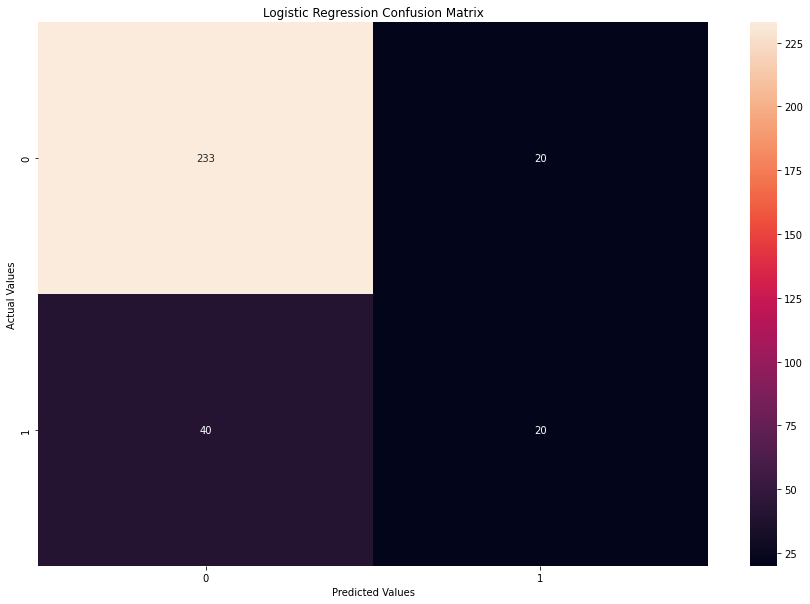

In [176]:
plot_confusion_matrix('Logistic Regression', y_test, y_pred)

In [177]:
y_pred_probs = lr.predict_proba(X_test)[:,1]
print(f'The Probability is: {y_pred_probs[0]}')
print('The AUC Score is:',roc_auc_score(y_test, y_pred_probs))

The Probability is: 0.13741427836434708
The AUC Score is: 0.8360342555994731


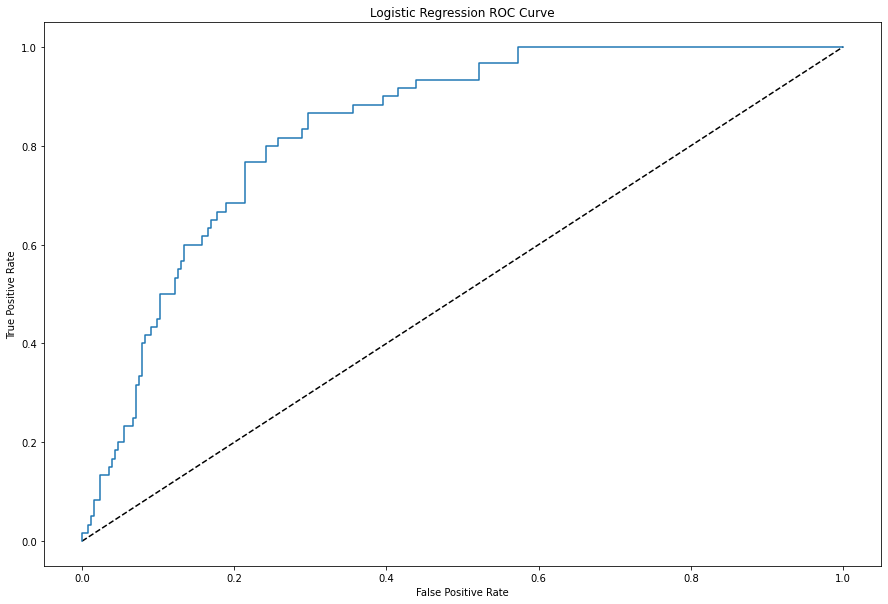

In [178]:
plot_roc_curve('Logistic Regression', y_test, y_pred_probs)

Text(0.5, 0, 'Importance Score')

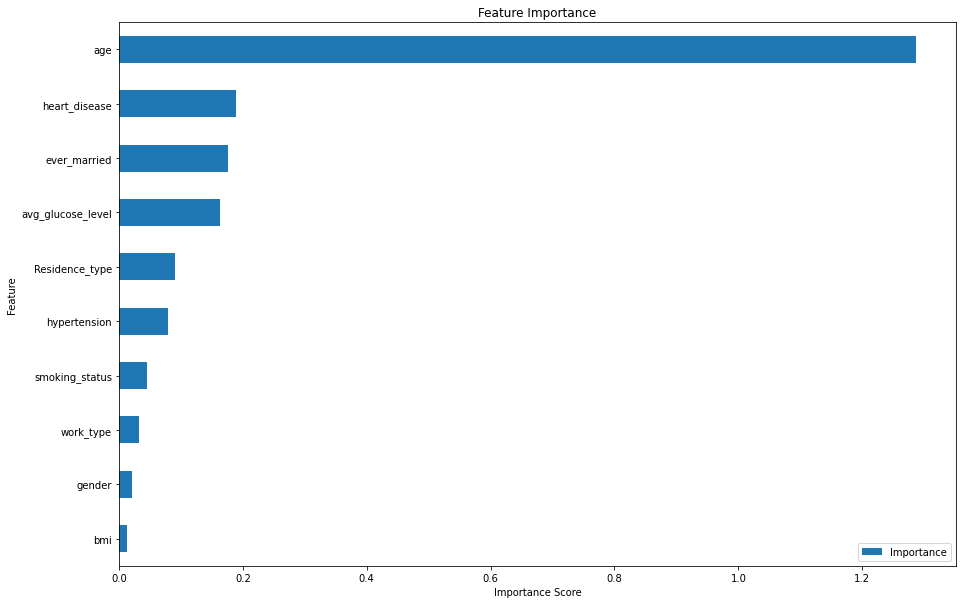

In [198]:
coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(15, 10))
plt.title('Feature Importance')
plt.xlabel('Importance Score')

## XGBOOST
What is XGBoost?
XGBoost is a classification algorithm that is designed for problems that have lots of training data that can be used to create a classifier. \
XGBoost provides parallel tree boosting. XGBoost takes the training data to train a model then it evaluates the model into the new data, this data keeps on repeating until the model cannot improve anymore.

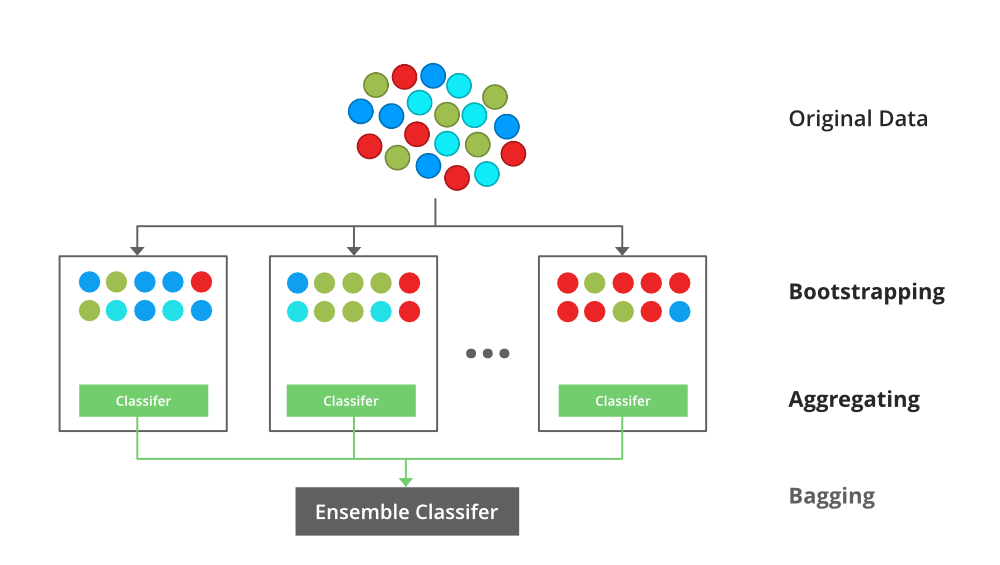

Source: https://www.simplilearn.com/what-is-xgboost-algorithm-in-machine-learning-article#:~:text=XGBoost%20is%20a%20classification%20algorithm,that%20you%20want%20to%20classify.

In [201]:
xgb = XGBClassifier(learning_rate=0.1, eval_metric = 'error')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred)
print(f'The Score for XGB Classifier is: {xgb_acc}')

The Score for XGB Classifier is: 0.8274760383386581


In [202]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       253
           1       0.57      0.40      0.47        60

    accuracy                           0.83       313
   macro avg       0.72      0.66      0.68       313
weighted avg       0.81      0.83      0.82       313



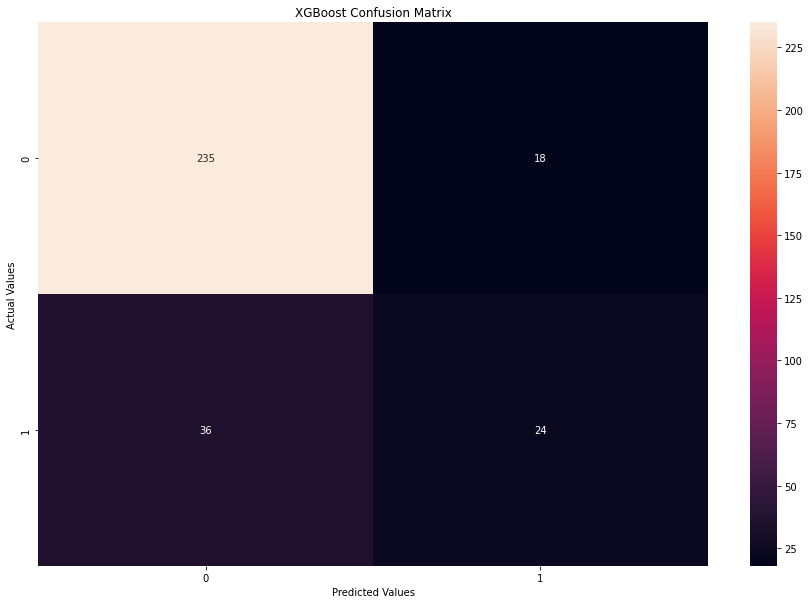

In [203]:
plot_confusion_matrix('XGBoost', y_test, y_pred)

In [206]:
y_pred_probs = xgb.predict_proba(X_test)[:,1]
print(f'The Probability is: {y_pred_probs[0]}')
print('The AUC Score is:',roc_auc_score(y_test, y_pred_probs))

The Probability is: 0.06001526862382889
The AUC Score is: 0.8143610013175231


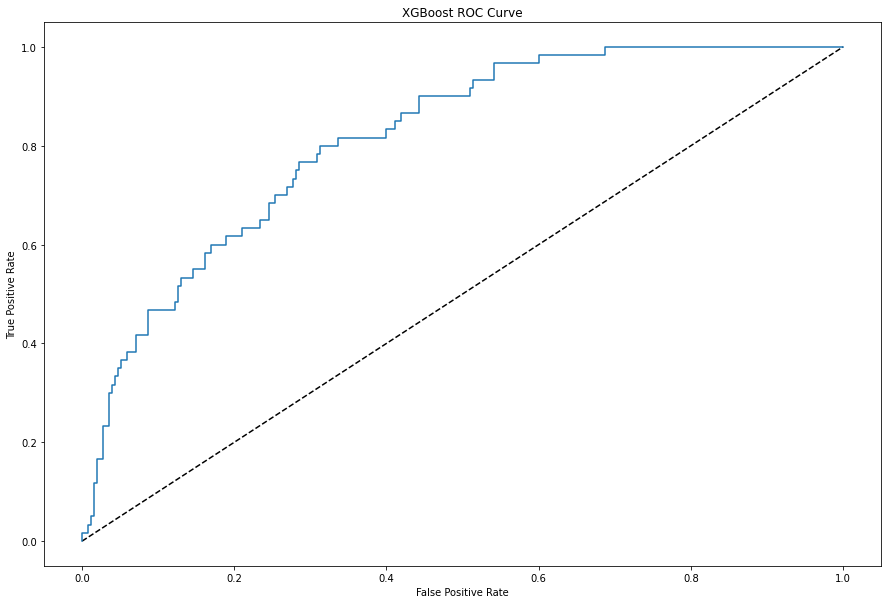

In [207]:
plot_roc_curve('XGBoost', y_test, y_pred_probs)

## Support Vector Machines:
What is a support vector machine? 
The support vector machine algorithm attempts to find a hyperplane in the N-dimensional space that could distinctly classify a data point in the plane. It attempts to find the optimal hyperplane with maximum marigins indicating the furthest each classification vector can go to classify data points.\
A fair warning is that these vector machines ARE prone to ouliers. \
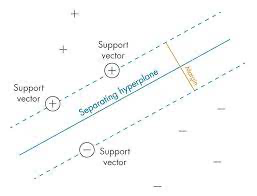 \
Source: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47


In [194]:
model_svm = SVC(kernel = 'linear', random_state = 0)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred)
print(f'The support vector machine accuracy is: {accuracy_svm}')

The support vector machine accuracy is: 0.792332268370607


In [197]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       292
           1       0.13      0.38      0.20        21

    accuracy                           0.79       313
   macro avg       0.54      0.60      0.54       313
weighted avg       0.89      0.79      0.83       313



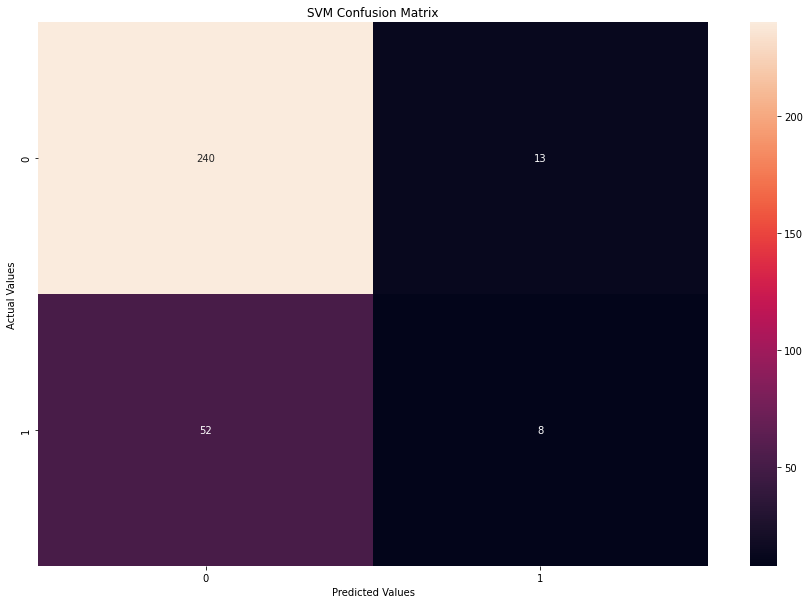

In [200]:
plot_confusion_matrix('SVM', y_test, y_pred)

[0.1   0.325 0.55  0.775 1.   ]
[ 25  81 137 193 250]
[[0.96       0.92       0.92       0.92       0.92      ]
 [0.90123457 0.87654321 0.86419753 0.86419753 0.86419753]
 [0.86861314 0.83941606 0.84671533 0.83211679 0.83211679]
 [0.83419689 0.82901554 0.82901554 0.8238342  0.84455959]
 [0.836      0.828      0.824      0.808      0.84      ]]
[[0.82539683 0.79365079 0.77777778 0.79032258 0.74193548]
 [0.76190476 0.80952381 0.82539683 0.87096774 0.79032258]
 [0.79365079 0.80952381 0.84126984 0.79032258 0.75806452]
 [0.82539683 0.82539683 0.85714286 0.79032258 0.77419355]
 [0.82539683 0.80952381 0.82539683 0.80645161 0.77419355]]
[0.928      0.87407407 0.84379562 0.83212435 0.8272    ]


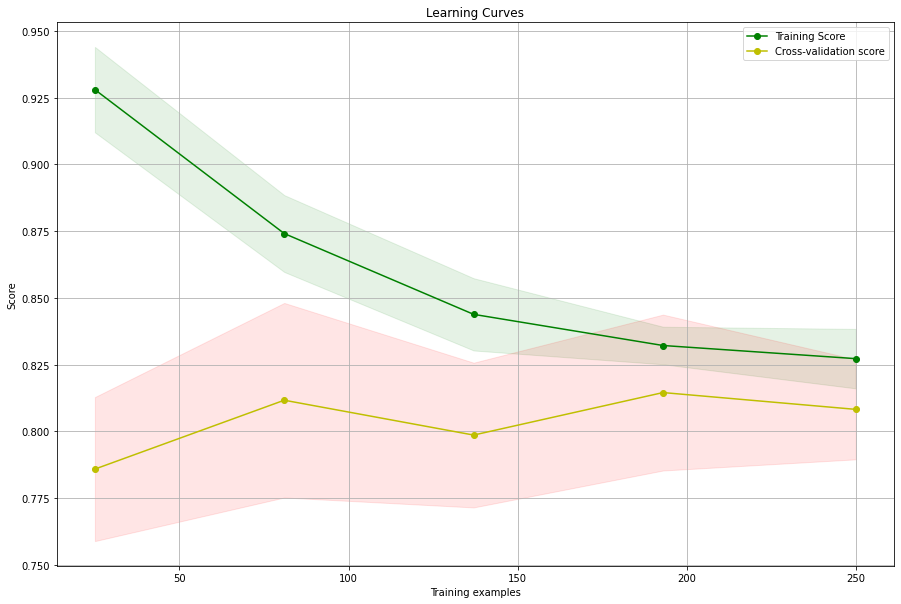

In [205]:
plot_learning_curve(X_test, y_test, model_svm, 5)

## Choosing the model

In [199]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest Classifier', 'XG Boost', 'SVC'],
    'Score': [lr_acc, rf_acc, xgb_acc, accuracy_svm]
 })
models = models.sort_values('Score', ascending = False)
models

,Model,Score
2,XG Boost,0.827476
0,Logistic Regression,0.808307
1,Random Forest Classifier,0.805112
3,SVC,0.792332


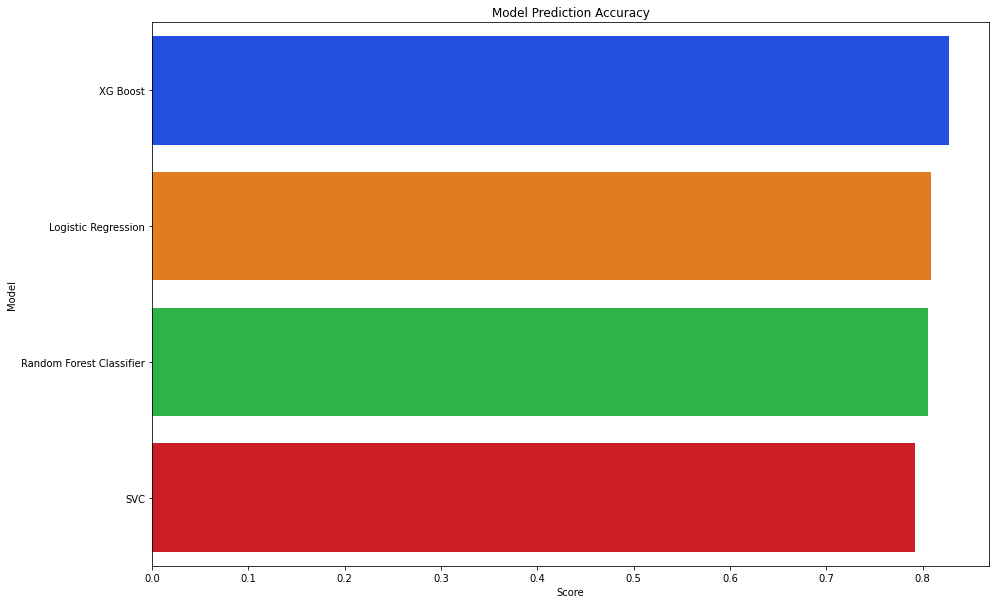

In [208]:
plt.figure(figsize = (15,10))
sns.barplot(data = models, 
            y = 'Model', 
            x = 'Score',
            palette = 'bright')
plt.title('Model Prediction Accuracy')
plt.show()

## Conclusion:

- It appears that XGBoost has the highest score out of other models for the upscaled data, though there are small differences.
- Based on the logistic regression model and the random forest model, it appears that age has the biggest impact in terms of feature importance, therefore age plays a big role in the cause of stroke.
- Majority of the subjects the data was collected from has never smoked or their status is unknown.

Thank you for taking the time to look through my notebook!